# Stanley Controller following a straight line

We need the follwing packages to be installed: `numpy` and `matplotlib` and `scipy`.
Additionally we need the follwing python files (should be placed in the same folder): `Model_Vehicle.py` and `Trajectory_LaneChange.py`<br>

Literature explaing the controller can be found e.g. at:<br>
G. M. Hoffmann, C. J. Tomlin, M. Montemerlo, and S. Thrun, “Autonomous Automobile Trajectory Tracking for Off-Road Driving : Controller Design , Experimental Validation and Racing †,” pp. 2296–2301, 2007
http://ai.stanford.edu/~gabeh/papers/hoffmann_stanley_control07.pdf

In [1]:
from numpy import cos, sin, tan, arcsin, arctan2, pi

import scipy.integrate as sci

from Model_Vehicle import *
from Trajectory_LaneChange import referenceTrajectory
#from Trajectory_Straight import referenceTrajectory

We bundle all parameters within a seperate class `Parameters` to access them.
Two instances distinguish physical from simulation parameters.
These parameters are used to specify the vehicle and experiment setup.

In [2]:
class Parameters(object):
    pass

# Physical parameter
para     = Parameters()  # instance of class Parameters
para.l   = 2.850         # define car length [m]
para.w   = para.l * 0.3  # define car width [m]
para.ref_l = para.l      # define dist to reference point in vehicle (from rear)
para.k   = 10            # K
para.ksoft = 1           
para.dt  = 0.04          # controller step size [s]
para.maxDelta = 25 * pi / 180 # [rad]

# Simulation parameter
sim_para = Parameters()  # instance of class Parameters
sim_para.t0 = 0          # start time
sim_para.tf = 2          # final time
sim_para.dt = para.dt    # step-size

In the next cell the controller is defined in `control` as well as the control error calculation that is controller specific and defined in `controlErrorEGOFront`.

In [3]:
##################################################################################
def control(e, xc, p, t):
    """Function of the control law
    Args:
        e:  control error (controller specific)
        xc: state vector controller from last step (only applies for controller with internal states)
        t:  time (to enable time dependent control laws like fade in/out etc.)
    Returns:
        u:  control vector
        xc: updated state vector controller (save internal state for next call)
    """
    e_fa, theta_e = e                          # extract two parts of the control error

    vx = p.vx                                  # get the vehicle velocity (const parameter)
    u1 = vx

    u2=0        # ADD here the control 
    u2 = np.minimum(np.maximum(u2, -p.maxDelta), p.maxDelta)   # saturation of steering angle

    return np.array([u1, u2]).T, xc  

##################################################################################
def controlErrorEGOFront(x, r, t, p):

    x, y, theta = x  # state vector

    i = np.int(t/p.dt+0.1)

    e_fa = r[i,1] -(y + p.l * sin(theta))  # front wheel position
                                    # negative if vehicle is left of traj
    theta_e = r[i,2] - theta  # orientation error (reference orientation const.0)

    return np.array([e_fa, theta_e]).T

Next the controller and the vehicle are simulated in closed loop.
Initial states (position) can be changed to investigate the reaction
to offsets.

In [4]:
# initial state ##################################################################
sim_para.x0 = [0, 5, 0]
sim_para.xc0 = [0,0] # controller states
para.vx = 70 / 3.6  # vehicle speed

The reference trajectory is provided within a predifined subfunction `referenceTrajectory`

In [5]:
# reference ######################################################################
r_traj = referenceTrajectory(para, sim_para)

Simulation is executed and resulting states are saved.

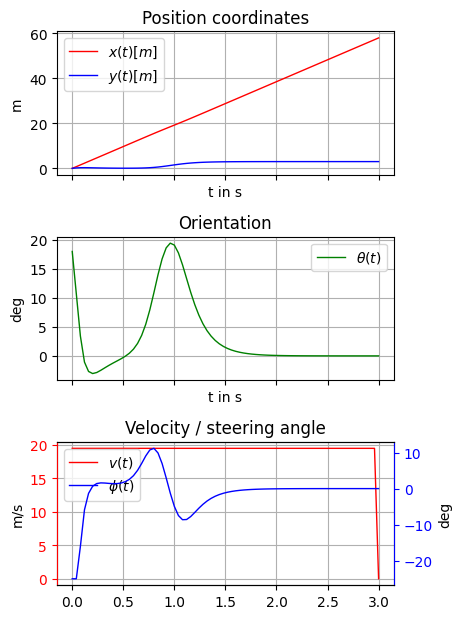

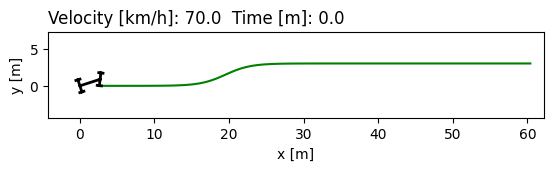

ImportError: cannot import name 'controlStanley' from 'CarControl_Stanley2' (/Users/crocodileandi/Library/Mobile Documents/com~apple~CloudDocs/FH/Master/3.Semester/AutonomousDriving/Exercise/autonomousedriving/CarControl_Stanley2.py)

In [6]:
from CarControl_Stanley2 import controlStanley

# simulation #####################################################################
tt = np.arange(sim_para.t0, sim_para.tf + sim_para.dt, sim_para.dt)  # time vector

x_traj = np.zeros([len(tt), len(sim_para.x0)])  # init state trace
x_traj[0, :] = sim_para.x0  # set initial state
u_traj = np.zeros([len(tt), 2])
xc = [0, 0]  # controller states
e_traj = np.zeros([len(tt), 2])  # init state trace
xc = sim_para.xc0

for t_i in np.arange(len(tt) - 1):  # loop over time instances

    # error model
    e_traj[t_i] = controlErrorEGOFront(x_traj[t_i], r_traj, tt[t_i], para)
    # control law
    para.u, xc = controlStanley(e_traj[t_i], xc, para, tt[t_i])  # get control
    u_traj[t_i] = para.u
    # vehicle motion
    sol = sci.solve_ivp(lambda t, x: ode(x, t, para),
                        (tt[t_i], tt[t_i + 1]), x_traj[t_i, :],
                        method='RK45', t_eval=tt[t_i + 1:t_i + 2])
    x_traj[t_i + 1, :] = sol.y.T  # size = len(x) x len(tt) (.T -> transpose)

Plots are generated

In [ ]:
# plot ###########################################################################
plt.rcParams['figure.dpi'] = 100 
plot_data(x_traj, u_traj, r_traj, tt, 12, 16, 'state_trajectory_Stanley_Straight', save=False)

Finally the motion is plotted in a 2D birds-eye view for later analysis.

In [ ]:
# animation ######################################################################
plt.rcParams['figure.dpi'] = 200 
ani = car_animation(x_traj, u_traj, r_traj, tt, para, x_traj, 'state_trajectory_Stanley_Straight')
plt.close()
ani

In [ ]:
plt.rcParams['animation.ffmpeg_path'] = 'ffmpeg'
#plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg'
ani.save('CarControl_Stanley_Straight.mp4')